In [21]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [22]:
MIN = 12

In [23]:
import pandas as pd
def get_train_test_data(path='data/book_store_sales.csv', split=0.8):
    df = pd.read_csv(path)
    sales = df["Value"].to_numpy()
    split = int(len(sales) * split)
    train_sales = sales[0:split]
    test_sales = sales[split:]
    return train_sales, test_sales

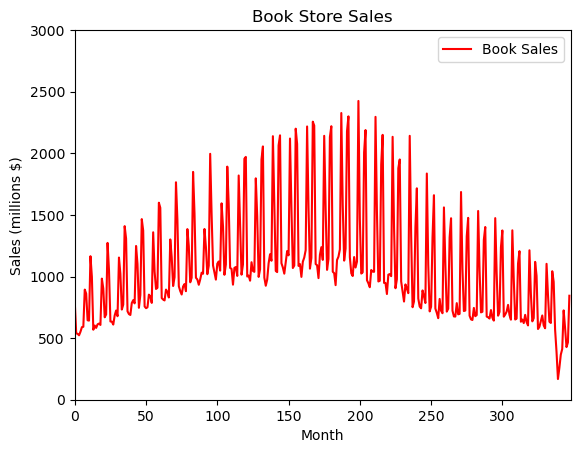

In [24]:
train_sales, test_sales = get_train_test_data()
all_data = np.concatenate([train_sales, test_sales])
months = range(len(all_data))
plt.plot(months, all_data, '-r', label='Book Sales')
plt.title('Book Store Sales')
plt.axis([0, len(all_data), 0.0, 3000.0])
plt.xlabel('Month')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()


In [25]:
mean = np.mean(train_sales)
std = np.std(train_sales)
train_sales = (train_sales - mean) / std
test_sales = (test_sales - mean) / std

In [26]:
# Create train examples.
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1), dtype=np.float32)
train_y = np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_sales[0:i+MIN]
    train_y[i, 0] = train_sales[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1), dtype=np.float32)
test_y = np.zeros((test_months-MIN, 1), dtype=np.float32)
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_sales[0:i+MIN]
    test_y[i, 0] = test_sales[i+MIN]

In [27]:
train_X_pt = torch.from_numpy(train_X)
train_y_pt = torch.from_numpy(train_y)
train_ds = TensorDataset(train_X_pt, train_y_pt)

test_X_pt = torch.from_numpy(test_X)
test_y_pt = torch.from_numpy(test_y)
test_ds = TensorDataset(test_X_pt, test_y_pt)


In [28]:
class RNNBasic(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNBasic, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True, nonlinearity='relu')

    def forward(self, x):
        out, h = self.rnn(x)
        return h[0]    


model = nn.Sequential(
    RNNBasic(input_size=1, hidden_size=128, num_layers=1),
    nn.Linear(128, 1)
)   


In [33]:
from scratch_lstm import LSTMLayer
from torch.nn import LSTM
model_new = nn.Sequential(
    LSTMLayer(input_features=1, layer_size=8),
    nn.Linear(8, 1)
)
class GetLastHidden(nn.Module):
    def forward(self, x):
        return x[1][0]

model_new = nn.Sequential(
    LSTM(input_size=1, hidden_size=64, num_layers=3),
    GetLastHidden(),
    nn.Linear(64, 1)
)

def train(model, epochs=150):
    train_dl = DataLoader(dataset=train_ds, batch_size=16, num_workers=12, shuffle=True)
    valid_dl = DataLoader(test_ds, batch_size=16, num_workers=12, shuffle=False)
    loss_criterion = nn.MSELoss()
    mae = nn.L1Loss()
    device = torch.device('cuda:0')
    optim = torch.optim.Adam(params=model.parameters(), lr=1e-4)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            optim.zero_grad()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            x_batch = x_batch.permute(1, 0, 2)
            y_pred = model(x_batch)[0]
            loss = loss_criterion(y_pred, y_batch)
            loss.backward()
            optim.step()
        
        model.eval()
        iter = 0
        avg_metric = 0.0
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                x_batch = x_batch.permute(1, 0, 2)
                y_pred = model(x_batch)[0]
                metric = mae(y_pred, y_batch)
                last_loss = loss_criterion(y_pred, y_batch)
                avg_metric = ((avg_metric*iter)+metric)/(iter+1)
                iter += 1
        # Pretty print epoch and metric.
        print(f'Epoch: {epoch+1}, MAE: {avg_metric:.4f}, Loss: {last_loss:.4f}')


train(model_new, epochs=100)

Epoch: 1, MAE: 1.0823, Loss: 2.8026
Epoch: 2, MAE: 1.0749, Loss: 2.7582
Epoch: 3, MAE: 1.0650, Loss: 2.7050
Epoch: 4, MAE: 1.0589, Loss: 2.6696
Epoch: 5, MAE: 1.0487, Loss: 2.6162
Epoch: 6, MAE: 1.0404, Loss: 2.5706
Epoch: 7, MAE: 1.0323, Loss: 2.5261
Epoch: 8, MAE: 1.0254, Loss: 2.4871
Epoch: 9, MAE: 1.0189, Loss: 2.4489
Epoch: 10, MAE: 1.0057, Loss: 2.3837
Epoch: 11, MAE: 0.9962, Loss: 2.3339
Epoch: 12, MAE: 0.9835, Loss: 2.2705
Epoch: 13, MAE: 0.9675, Loss: 2.1868
Epoch: 14, MAE: 0.9487, Loss: 2.0891
Epoch: 15, MAE: 0.9162, Loss: 1.9335
Epoch: 16, MAE: 0.8804, Loss: 1.7605
Epoch: 17, MAE: 0.7980, Loss: 1.4045
Epoch: 18, MAE: 0.6393, Loss: 0.7740
Epoch: 19, MAE: 0.6295, Loss: 0.7351
Epoch: 20, MAE: 0.6333, Loss: 0.7377
Epoch: 21, MAE: 0.6411, Loss: 0.7673
Epoch: 22, MAE: 0.6174, Loss: 0.6976
Epoch: 23, MAE: 0.6369, Loss: 0.7666
Epoch: 24, MAE: 0.6359, Loss: 0.7771
Epoch: 25, MAE: 0.6330, Loss: 0.7748
Epoch: 26, MAE: 0.6343, Loss: 0.7867
Epoch: 27, MAE: 0.6331, Loss: 0.7871
Epoch: 28,

In [11]:
len(list(model_new.parameters()))

42

In [16]:
train(model, epochs=150)

RuntimeError: The size of tensor a (277) must match the size of tensor b (16) at non-singleton dimension 0